In [3]:
import numpy as np
import math
from matplotlib import pyplot as plt

# I set up in a array all the y for y = sin(x)

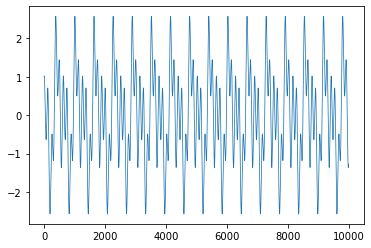

In [4]:
n = 10000

array = np.array([math.sin(i*0.02) + math.cos(i*.05) - math.sin(i*0.01) for i in range(1, n)])
fig, ax = plt.subplots()
ax.plot([i for i in range(1, n)], array, linewidth=0.75)
plt.show()

# I am calculating an index (between 0 and 1) for each y 
#### If in the future 150 y, the value is mostly going up, then the index is going to be close to 1
#### If in the future 150 y, the value is mostly going down, then the index is going to be close to 0

##### I call it here : SELL_INDEX

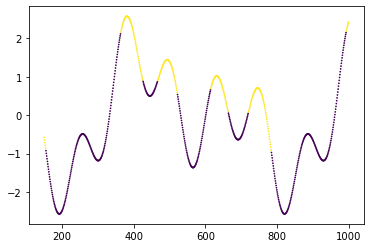

In [5]:
SELL_INDEX = np.zeros((len(array), 1))

for index, row in enumerate(array):
    
    if index > len(array) - 150:
        continue

    max_price = np.amax(array[index:index + 150])
    min_price = np.amin(array[index:index + 150])
    
    current_sell_index = (row - min_price) / (max_price - min_price)
    
    SELL_INDEX[index][0] = 1 if current_sell_index > 0.8 else 0

data_with_sell_index = np.hstack((array.reshape(-1,1), SELL_INDEX))
data_final =  np.hstack( (data_with_sell_index,  np.arange(len(data_with_sell_index)).reshape(-1, 1)) )
data_final = data_final[:len(data_final) - 150]
fig, ax = plt.subplots()
ax.scatter(data_final[150:1000][:,2], data_final[150:1000][:,0] , c = data_final[150:1000][:,1], s = .5)
plt.show()

# I set up the model 

In [6]:
import tensorflow as tf
from tensorflow.python.keras import models, Input, Model
from tensorflow.python import keras
from tensorflow.python.keras.layers import LSTM, Dense, Dropout

## We implement a reducer for the learning rate

In [7]:
class LearningRateReducerCb(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs={}):
        old_lr = self.model.optimizer.lr.read_value()
        new_lr = old_lr * 0.99
        print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
        self.model.optimizer.lr.assign(new_lr)


In [8]:

input_layer = Input(shape=(150, 1))
layer_1_lstm = LSTM(50, return_sequences=True)(input_layer)
dropout_1 = Dropout(0.1)(layer_1_lstm)
layer_2_lstm = LSTM(50, return_sequences=True)(dropout_1)
dropout_2 = Dropout(0.1)(layer_2_lstm)
layer_3_lstm = LSTM(50)(dropout_2)

output_sell_index_proba = Dense(1, activation='sigmoid')(layer_3_lstm)

model = Model(inputs=input_layer, outputs=output_sell_index_proba)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.BinaryAccuracy()])
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 1)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 150, 50)           10400     
_________________________________________________________________
dropout (Dropout)            (None, 150, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 150, 50)           20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51    

#### Batch generation, I associate the last sequence n - 150 to n with the n SELL_INDEX

In [9]:
def generate_batch(dataset_x, dataset_y, sequence_length):
    x_data, y_data = [], []
    for i in range(len(list(zip(dataset_x, dataset_y))) - sequence_length - 1):
        x_data.append(dataset_x[i:i + sequence_length])
        y_data.append(dataset_y[i + sequence_length])
    return np.array(x_data), np.array(y_data)

In [10]:
x, y = generate_batch(data_final[:,0][:9000], data_final[:,1][:9000], sequence_length=150)
x = x.reshape(x.shape[0], x.shape[1], 1)
y = y.reshape(x.shape[0], 1, 1)

print(x.shape, y.shape)

model.fit(x, y, callbacks=[LearningRateReducerCb()], epochs=10,
                   validation_split=0.1, batch_size=64, verbose=1)

(8849, 150, 1) (8849, 1, 1)
Epoch 1/10


2022-06-17 18:27:24.094533: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


125/125 [==============================] - 29s 212ms/step - loss: 0.2629 - binary_accuracy: 0.8869 - val_loss: 0.1526 - val_binary_accuracy: 0.9367

Epoch: 0. Reducing Learning Rate from 0.0010000000474974513 to 0.0009900000877678394
Epoch 2/10
125/125 [==============================] - 27s 218ms/step - loss: 0.0999 - binary_accuracy: 0.9540 - val_loss: 0.0719 - val_binary_accuracy: 0.9672

Epoch: 1. Reducing Learning Rate from 0.0009900000877678394 to 0.000980100128799677
Epoch 3/10
125/125 [==============================] - 27s 216ms/step - loss: 0.0797 - binary_accuracy: 0.9689 - val_loss: 0.0530 - val_binary_accuracy: 0.9831

Epoch: 2. Reducing Learning Rate from 0.000980100128799677 to 0.0009702991228550673
Epoch 4/10
125/125 [==============================] - 27s 217ms/step - loss: 0.0419 - binary_accuracy: 0.9848 - val_loss: 0.0341 - val_binary_accuracy: 0.9876

Epoch: 3. Reducing Learning Rate from 0.0009702991228550673 to 0.0009605961386114359
Epoch 5/10
125/125 [=============

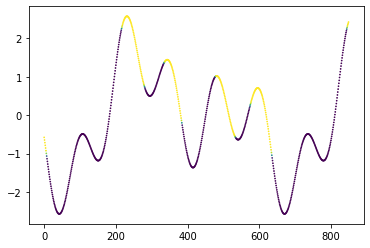

In [9]:
data = np.array(data_final[:,0][9000:])
results = np.array([])
for i in range (150, 1000):
    result = model.predict(data[i - 150 : i].reshape(1, 150, 1))
    results = np.append(result, results)
        
data = data[150:1000]

fig, ax = plt.subplots()
ax.scatter([range(len(data))], data.flatten() , c = results.flatten(), s= .5)
plt.show()